In [3]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

In [4]:
train_x = torch.linspace(0, 1, 2000)
train_y = torch.sin(train_x * (4 * math.pi) + torch.randn(train_x.size()) * 0.2)
train_x

tensor([0.0000e+00, 5.0025e-04, 1.0005e-03,  ..., 9.9900e-01, 9.9950e-01,
        1.0000e+00])

In [5]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that. 
        # Here we are using a grid that has the same number of points as the training data (a ratio of 1.0). 
        # Performance can be sensitive to this parameter, so you may want to adjust it for your own problem on a validation set.
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(), grid_size=grid_size, num_dims=1
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

In [7]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 30


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

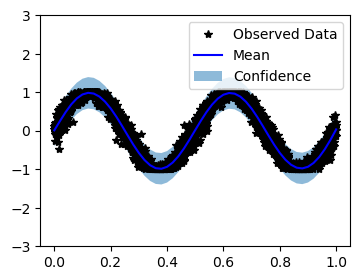

In [8]:
# Put model & likelihood into eval mode
model.eval()
likelihood.eval()

# Initalize plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    prediction = likelihood(model(test_x))
    mean = prediction.mean
    # Get lower and upper predictive bounds
    lower, upper = prediction.confidence_region()

# Plot the training data as black stars
def ax_plot():
    if smoke_test: return  # this is for running the notebook in our testing framework

    ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.detach().numpy(), mean.detach().numpy(), 'b')
    # Plot confidence bounds as lightly shaded region
    ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

ax_plot()